## VAE digits

In [1]:
import torch.nn as nn

In [2]:
import numpy as np
import json
import os
import pickle

In [3]:
import torch
import torch.optim as optim

In [4]:
import collections

In [5]:
from torchsummary import summary as torch_network_summary

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

In [7]:
from tqdm import tqdm_notebook as tqdm

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class Encoder_part(nn.Module):
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        , use_VAE = False
        ):
        super(Encoder_part, self).__init__()

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.input_filter = self.input_dim[0]
        self.encoder_conv_filters_input = [self.input_filter] + encoder_conv_filters[:-1]
        self.encoder_conv_filters_output = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.z_dim = z_dim
        
        self.use_VAE = use_VAE

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        
        self.conv_layers = nn.Sequential()
        self.output_shape = collections.OrderedDict()
        
        self.output_shape['Input'] = self.input_dim
        current_layer_name = 'Input'
        current_input_shape = self.output_shape[current_layer_name]
        
        for i in range(self.n_layers_encoder):
            
            current_filter, input_H, input_W = current_input_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)
            
            kernel = self.encoder_conv_kernel_size[i]
            stride = self.encoder_conv_strides[i]
            
            _output_H = int((input_H-kernel)/stride) + 1
            _output_W = int((input_W-kernel)/stride) + 1
            
            if int(input_H/stride) != _output_H:
                padding = max(0, int((kernel-(_output_H%stride))/2))
            else:
                padding = 0
            
            output_H = int((input_H-kernel+2*padding)/stride) + 1
            output_W = int((input_W-kernel+2*padding)/stride) + 1
            
            self.output_shape[current_layer_name] = [self.encoder_conv_filters_output[i], output_H, output_W]
            current_input_shape = self.output_shape[current_layer_name]
            
            self.conv_layers.add_module(current_layer_name,
                            nn.Conv2d(self.encoder_conv_filters_input[i]
                                    , self.encoder_conv_filters_output[i]
                                    , kernel_size = self.encoder_conv_kernel_size[i]
                                    , stride = self.encoder_conv_strides[i]
                                    , padding = padding
                                    ))
            if self.use_batch_norm:
                
                self.conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                            nn.BatchNorm2d(self.encoder_conv_filters_output[i]))

            self.conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())

            if self.use_dropout:
                self.conv_layers.add_module('Layer {} Dropout2d'.format(i), nn.Dropout2d(p=0.25))
        
        self.encoder_cnn_output_shape = current_input_shape
        self.Flattened_shape = np.prod(self.encoder_cnn_output_shape)
        self.Flattened = nn.Linear(self.Flattened_shape, self.z_dim)
        
        if self.use_VAE:
            self.mu = nn.Linear(self.Flattened_shape, self.z_dim)
            self.log_var = nn.Linear(self.Flattened_shape, self.z_dim)
            self.kl_loss = None
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size()[0],-1)
        flattened = self.Flattened(x)
        
        if self.use_VAE:
            epsilon = torch.randn(flattened.size()[1:]).to(device)
            mu = self.mu(x)
            log_var = self.log_var(x)
            encoder_output = mu + torch.exp(log_var/2) * epsilon
            
            self.kl_loss =  -0.5 * (1 + log_var - mu**2 - torch.exp(log_var)).sum()
            
        else:
            encoder_output = flattened
            
        return encoder_output
        

In [10]:
class Decoder_part(nn.Module):
    def __init__(self
        , encoder_cnn_output_shape
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):
        super(Decoder_part, self).__init__()
    
        self.encoder_cnn_output_shape = encoder_cnn_output_shape
        self.decoder_conv_t_filters_input = [encoder_cnn_output_shape[0]] + decoder_conv_t_filters[:-1]
        self.decoder_conv_t_filters_output = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_decoder = len(decoder_conv_t_filters)
        
        
        self.conv_layers = nn.Sequential()
        self.output_shape = collections.OrderedDict()
        
        self.output_shape['Input'] = self.encoder_cnn_output_shape
        current_layer_name = 'Input'
        current_input_shape = self.output_shape[current_layer_name]
        
        self.Reshaping = nn.Linear(self.z_dim, np.prod(self.encoder_cnn_output_shape))
        
        for i in range(self.n_layers_decoder):
            
            current_filter, input_H, input_W = current_input_shape
            current_layer_name = 'Layer {} Conv2d'.format(i)
            
            kernel = self.decoder_conv_t_kernel_size[i]
            stride = self.decoder_conv_t_strides[i]
            
            _output_H = (input_H-1)*stride + kernel
            _output_W = (input_W-1)*stride + kernel
            
            if int(input_H*stride) != _output_H:
                padding = (_output_H-input_H*stride)/2
                if padding%1 == 0.5:
                    padding = max(0, int(padding)) + 1
                    output_padding = 1
                else:
                    padding = int(padding)
                    output_padding = 0
            else:
                padding = 0
                output_padding = 0
            
            output_H = (input_H-1)*stride + kernel - 2*padding + output_padding
            output_W = (input_W-1)*stride + kernel - 2*padding + output_padding
            
            self.output_shape[current_layer_name] = [self.decoder_conv_t_filters_output[i], output_H, output_W]
            current_input_shape = self.output_shape[current_layer_name]
            
            self.conv_layers.add_module(current_layer_name,
                            nn.ConvTranspose2d(self.decoder_conv_t_filters_input[i]
                                    , self.decoder_conv_t_filters_output[i]
                                    , kernel_size = self.decoder_conv_t_kernel_size[i]
                                    , stride = self.decoder_conv_t_strides[i]
                                    , padding = padding
                                    , output_padding = output_padding
                                    ))
            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    self.conv_layers.add_module('Layer {} BatchNorm2d'.format(i), 
                                                nn.BatchNorm2d(self.decoder_conv_t_filters_output[i]))

                self.conv_layers.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU())

                if self.use_dropout:
                    self.conv_layers.add_module('Layer {} Dropout2d'.format(i), nn.Dropout2d(p=0.25))
            else:
                self.conv_layers.add_module('Layer {} Sigmoid'.format(i), nn.Sigmoid())
        
    def forward(self, x):
        x = self.Reshaping(x)
        x = x.reshape([x.size()[0]]+self.encoder_cnn_output_shape)
        x = self.conv_layers(x)
        
        return x

In [11]:
class Autoenocoder_pt(nn.Module):
    def __init__(self,
                encoder, decoder):
        super(Autoenocoder_pt, self).__init__()
        self.encoder_part = encoder_part
        self.decoder_part = decoder_part
        
    def forward(self, x):
        x = self.encoder_part(x)
        x = self.decoder_part(x)
        
        return x

## Training

In [121]:
channels, H, W = 1, 28, 28

In [122]:
sample_input = torch.rand(1,channels, H, W).to(device)
input_dim = sample_input.cpu().numpy().shape[1:]

In [123]:
encoder_conv_filters = [32,64,64, 64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
z_dim = 2

In [124]:
use_VAE_mode = True

In [125]:
encoder_part = Encoder_part(
            input_dim = input_dim
        , encoder_conv_filters = encoder_conv_filters
        , encoder_conv_kernel_size = encoder_conv_kernel_size
        , encoder_conv_strides = encoder_conv_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
        , use_VAE = use_VAE_mode
).to(device)

In [126]:
decoder_part = Decoder_part(
        encoder_cnn_output_shape = encoder_part.encoder_cnn_output_shape
        , decoder_conv_t_filters = decoder_conv_t_filters
        , decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        , decoder_conv_t_strides = decoder_conv_t_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
).to(device)

In [127]:
AE = Autoenocoder_pt(encoder_part, decoder_part)

torch_network_summary(AE, encoder_part.input_dim)

In [128]:
from utils.loaders import load_mnist, load_model
from torch.utils.data import DataLoader

In [129]:
(_x_train, y_train), (_x_test, y_test) = load_mnist()
_x_train_t = np.transpose(_x_train, (0,3,1,2))
_x_test_t = np.transpose(_x_test, (0,3,1,2))

x_train = torch.from_numpy(_x_train_t).to(device)
x_test = torch.from_numpy(_x_test_t).to(device)

input_data = [[x_item, y_item] for x_item, y_item in zip(_x_train_t, y_train)]

In [130]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [131]:
optimizer = optim.Adam(AE.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss().to(device)

In [132]:
EPOCHS = 100

AE.train()

best_loss = 0
early_stopping_count = 0
total_loss_list = []
total_r_loss_list = []
total_kl_loss_list = []

for epoch in range(EPOCHS):
    total_loss = 0
    total_r_loss = 0
    total_kl_loss = 0
    for x_batch, y_batch in tqdm(DataLoader(input_data, 32, True)):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        decoder_output = AE(x_batch)
        
        r_loss = criterion(x_batch, decoder_output)
        total_r_loss += r_loss.item()
        if AE.encoder_part.use_VAE:
            kl_loss = AE.encoder_part.kl_loss
            loss = R_LOSS_FACTOR * r_loss + kl_loss
            
            total_kl_loss += kl_loss.item()
        else:
            loss = r_loss
        
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    if epoch == 0:
        best_loss = total_loss
    else:
        if total_loss < best_loss:
            best_loss = total_loss
            early_stopping_count += 1
    total_loss_list.append(total_loss)
    total_r_loss_list.append(total_r_loss)
    
    if AE.encoder_part.use_VAE:
        total_kl_loss_list.append(total_kl_loss)
        
        info2print = '{}  {}  {}  {}'.format(epoch, total_loss, total_r_loss, total_kl_loss)
    else:
        info2print = '{}  {}  {}'.format(epoch, total_loss, total_r_loss)
    
    print(info2print)
    if early_stopping_count>=20:
        break

/home/hojun/.virtualenvs/gan/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



0  128857.06605148315  128.83262684568763  24.43932431936264



1  126299.8832244873  126.29742866382003  2.4543579816818237



2  126261.76258087158  126.25854399055243  3.2187950909137726



3  126249.36501693726  126.24697262048721  2.39232474565506



4  126238.34685516357  126.23665798828006  1.68855419754982



5  126216.00657272339  126.21277927607298  3.227247506380081



6  126197.88187026978  126.19583132117987  2.050579935312271



7  126201.98400115967  126.20114286988974  0.8410890400409698



8  126186.34479141235  126.1846787892282  1.666213035583496



9  126188.9326171875  126.18770363926888  1.2289599776268005



10  126182.59871673584  126.18133171647787  1.26709446310997



11  126175.67834472656  126.17441220209002  1.2660744190216064



12  126172.88679122925  126.17131586745381  1.5709302723407745



13  126175.61813735962  126.17437467724085  1.2435924708843231



14  126167.65032958984  126.16670994088054  0.9405408799648285



15  126163.20234298706  126.16225158050656  0.9505941271781921



16  126165.57400131226  126.16469803452492  0.8761554956436157



17  126157.12156677246  126.15642292797565  0.6985970735549927



18  126158.62558364868  126.15820534527302  0.4202563166618347



19  126159.4303855896  126.1586272791028  0.8030276000499725



20  126158.62536239624  126.15798753127456  0.6378104984760284



21  126156.30158615112  126.15568294376135  0.6184816360473633



22  126154.7416229248  126.1541829816997  0.5586904883384705



23  126152.25463867188  126.15152121335268  0.7332638800144196



24  126152.11602783203  126.15160550549626  0.5107672214508057



25  126151.8180770874  126.15131440386176  0.5038040280342102



26  126147.1063156128  126.14666655287147  0.43962258100509644



27  126147.17640304565  126.14630636572838  0.8699466586112976



28  126147.02292633057  126.14654561132193  0.47734352946281433


## Model Save

In [114]:
torch.save(AE.state_dict(), './models_saved/vae-20200209.pt')

In [118]:
channels, H, W = 1, 28, 28

sample_input = torch.rand(1,channels, H, W).to(device)
input_dim = sample_input.cpu().numpy().shape[1:]

encoder_conv_filters = [32,64,64, 64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
z_dim = 2

use_VAE_mode = False

encoder_part = Encoder_part(
            input_dim = input_dim
        , encoder_conv_filters = encoder_conv_filters
        , encoder_conv_kernel_size = encoder_conv_kernel_size
        , encoder_conv_strides = encoder_conv_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
        , use_VAE = use_VAE_mode
).to(device)

decoder_part = Decoder_part(
        encoder_cnn_output_shape = encoder_part.encoder_cnn_output_shape
        , decoder_conv_t_filters = decoder_conv_t_filters
        , decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        , decoder_conv_t_strides = decoder_conv_t_strides
        , z_dim = z_dim
#         , use_batch_norm = True
#         , use_dropout= True
).to(device)

In [119]:
model = Autoenocoder_pt(encoder_part, decoder_part)

In [120]:
model.load_state_dict(torch.load('./models_saved/ae-20200209.pt'))
model.eval()

Autoenocoder_pt(
  (encoder_part): Encoder_part(
    (conv_layers): Sequential(
      (Layer 0 Conv2d): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Layer 0 LeakyReLU): LeakyReLU(negative_slope=0.01)
      (Layer 1 Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (Layer 1 LeakyReLU): LeakyReLU(negative_slope=0.01)
      (Layer 2 Conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (Layer 2 LeakyReLU): LeakyReLU(negative_slope=0.01)
      (Layer 3 Conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Layer 3 LeakyReLU): LeakyReLU(negative_slope=0.01)
    )
    (Flattened): Linear(in_features=3136, out_features=2, bias=True)
  )
  (decoder_part): Decoder_part(
    (conv_layers): Sequential(
      (Layer 0 Conv2d): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (Layer 0 LeakyReLU): LeakyReLU(negative_slope=0.01)
      (Layer 1 Conv2d): ConvTr

## Analysis

In [109]:
(_x_train, y_train), (_x_test, y_test) = load_mnist()
_x_train_t = np.transpose(_x_train, (0,3,1,2))
_x_test_t = np.transpose(_x_test, (0,3,1,2))

x_train = torch.from_numpy(_x_train_t).to(device)
x_test = torch.from_numpy(_x_test_t).to(device)

In [110]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
_example_images = x_test[example_idx]

example_images = _example_images.cpu().numpy()

In [111]:
_z_points = model.encoder_part(_example_images)
z_points = _z_points.cpu().detach().numpy()

_reconst_images = model.decoder_part(_z_points)
reconst_images = _reconst_images.cpu().detach().numpy()

## AutoEncoder 결과

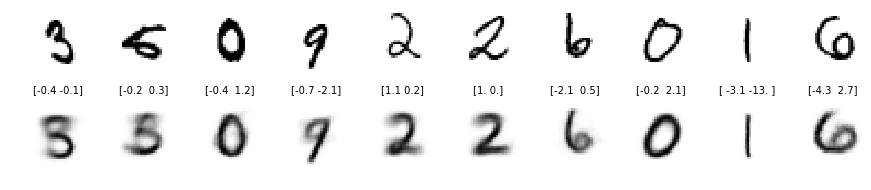

In [113]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

## Variational AutoEncoder 결과